In [1]:
# Thesis title: Forecasting different air pollutants concentration by deep learning methods

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # display figure inline in notebook
import plotly.express as px # view the timeseries data in a slider
import seaborn as sns
#sns.set(rc={'figure.figsize':(8,5)}) # set the seaborn default figrue size
sns.set()
sns.set_style('white') #possible choices: white, dark, whitegrid, darkgrid, ticks
sns.set(rc={'figure.figsize':(11,7)}, style="white", font_scale=1.4)#style="whitegrid"
plt.rcParams["axes.labelsize"] = 16

from datetime import datetime # converting the timestamp data into datetime object
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # determining autocorrelation
from scipy import stats # detecting outliers by z score

### Reading the data

In [2]:
cwd = os.getcwd() # dirname (abspath(__file__))
BASE_DIR = os.path.dirname(cwd)
DATA_DIR = os.path.join(BASE_DIR, 'Data_movingsite')

# saving the combined data into this directory
CACHE_DIR = os.path.join(BASE_DIR, 'cache_movingsite')
working_file = os.path.join(CACHE_DIR, 'moving-site-dataset.csv')

In [3]:
df1 = pd.read_csv(working_file)

In [4]:
df1.head()

,timestamp,spora-id,latitude,longitude,NO,NO2,O3,CO,BME680_pressure,BME680_humidity,BME680_temperature,comment,filename,Month
0,1550561649,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55,NaN,Month2.csv,Month2
1,1550561650,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56,NaN,Month2.csv,Month2
2,1550561651,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56,NaN,Month2.csv,Month2
3,1550561652,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57,NaN,Month2.csv,Month2
4,1550561653,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57,NaN,Month2.csv,Month2


### Data preprocessing

#### Cleaning the data

In [5]:
df1.shape

(6052856, 14)

In [6]:
# renaming columns
df1 = df1.rename(columns = {'timestamp': 'date','BME680_pressure':'pressure', 'BME680_humidity':'humidity', 'BME680_temperature':'temp'})

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6052856 entries, 0 to 6052855
Data columns (total 14 columns):
 #   Column     Dtype  
---  ------     -----  
 0   date       int64  
 1   spora-id   int64  
 2   latitude   float64
 3   longitude  float64
 4   NO         float64
 5   NO2        float64
 6   O3         float64
 7   CO         float64
 8   pressure   float64
 9   humidity   float64
 10  temp       float64
 11  comment    float64
 12  filename   object 
 13  Month      object 
dtypes: float64(10), int64(2), object(2)
memory usage: 646.5+ MB


In [8]:
# we see that date column is integer, so need to work on it
# converting the timestamp data into datetime object 
df1['date'] = pd.to_datetime(df1['date'],unit='s')
# df['date'] = pd.to_datetime(df['date'].astype(int), unit='s')
# df['date'] = pd.to_datetime(int(df['date']),unit='s')
df1.head()

,date,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp,comment,filename,Month
0,2019-02-19 07:34:09,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55,NaN,Month2.csv,Month2
1,2019-02-19 07:34:10,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56,NaN,Month2.csv,Month2
2,2019-02-19 07:34:11,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56,NaN,Month2.csv,Month2
3,2019-02-19 07:34:12,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57,NaN,Month2.csv,Month2
4,2019-02-19 07:34:13,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57,NaN,Month2.csv,Month2


In [9]:
# droping the unnecessary features
df1 = df1.drop(['comment', 'filename', 'Month'], axis=1)
df1.head()

,date,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp
0,2019-02-19 07:34:09,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55
1,2019-02-19 07:34:10,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56
2,2019-02-19 07:34:11,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56
3,2019-02-19 07:34:12,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57
4,2019-02-19 07:34:13,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57


In [10]:
# importing the spatial datasset: supersite dataset
df2= pd.read_csv('supersite_sub_df.csv')
df2.head()

,Unnamed: 0,date,NO_s,NO2_s,O3_s,CO_s
0,0,2019-02-20 09:31:14,0.020778,0.047479,0.033345,0.004883
1,1,2019-02-20 09:31:15,0.020778,0.047479,0.033345,0.004883
2,2,2019-02-20 09:31:16,0.020778,0.047479,0.033345,0.004883
3,3,2019-02-20 09:31:17,0.020778,0.047479,0.033345,0.004883
4,4,2019-02-20 09:31:18,0.020778,0.047479,0.033345,0.004883


In [11]:
# nerging two dataframe on 'date' column
df = pd.concat([df1, df2], axis=1)

In [12]:
df.head()

,date,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp,Unnamed: 0,date,NO_s,NO2_s,O3_s,CO_s
0,2019-02-19 07:34:09,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55,0.0,2019-02-20 09:31:14,0.020778,0.047479,0.033345,0.004883
1,2019-02-19 07:34:10,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56,1.0,2019-02-20 09:31:15,0.020778,0.047479,0.033345,0.004883
2,2019-02-19 07:34:11,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56,2.0,2019-02-20 09:31:16,0.020778,0.047479,0.033345,0.004883
3,2019-02-19 07:34:12,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57,3.0,2019-02-20 09:31:17,0.020778,0.047479,0.033345,0.004883
4,2019-02-19 07:34:13,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57,4.0,2019-02-20 09:31:18,0.020778,0.047479,0.033345,0.004883


In [13]:
# creating new dataframe keeping some columns and droping others
df= df.iloc[:, np.r_[0:11,13:17]]
df.head()

,date,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s
0,2019-02-19 07:34:09,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883
1,2019-02-19 07:34:10,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883
2,2019-02-19 07:34:11,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883
3,2019-02-19 07:34:12,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883
4,2019-02-19 07:34:13,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883


#### Missing values

In [14]:
# Printing details of the data
print('Rows :', df.shape[0])
print('Columns :', df.shape[1])
print('\nFeatures : \n', df.columns.tolist())
print('\nMissing values :\n', df.isnull().any())
print('\nUnique values : \n', df.nunique())

Rows : 6052856
Columns : 15

Features : 
 ['date', 'spora-id', 'latitude', 'longitude', 'NO', 'NO2', 'O3', 'CO', 'pressure', 'humidity', 'temp', 'NO_s', 'NO2_s', 'O3_s', 'CO_s']

Missing values :
 date         False
spora-id     False
latitude     False
longitude    False
NO            True
NO2           True
O3            True
CO            True
pressure     False
humidity     False
temp         False
NO_s          True
NO2_s         True
O3_s          True
CO_s          True
dtype: bool

Unique values : 
 date         4701667
spora-id           3
latitude       41568
longitude      63687
NO           1189907
NO2          1511894
O3           1073374
CO            619331
pressure        6565
humidity       54721
temp            4845
NO_s            7473
NO2_s           6525
O3_s           10405
CO_s            2129
dtype: int64


In [15]:
# Missing value counts
df.isnull().sum()

date               0
spora-id           0
latitude           0
longitude          0
NO            957820
NO2           957828
O3            984996
CO           1066577
pressure           0
humidity           0
temp               0
NO_s         4706816
NO2_s        4878356
O3_s         4179956
CO_s         5402696
dtype: int64

In [16]:
# Printing the percentage of null values in the dataset
print('percentage of null value : \n',df.isnull().sum()/len(df))

percentage of null value : 
 date         0.000000
spora-id     0.000000
latitude     0.000000
longitude    0.000000
NO           0.158243
NO2          0.158244
O3           0.162732
CO           0.176211
pressure     0.000000
humidity     0.000000
temp         0.000000
NO_s         0.777619
NO2_s        0.805959
O3_s         0.690576
CO_s         0.892586
dtype: float64


In [17]:
# printing percentage of negative value
cols=['NO', 'NO2', 'O3', 'CO', 'pressure', 'humidity', 'temp']
#df[df[cols] < 0].count()
print('percentage of negative value: \n', df[df[cols]<0].count()/len(df))

percentage of negative value: 
 date         0.000000
spora-id     0.000000
latitude     0.000000
longitude    0.000000
NO           0.408753
NO2          0.430180
O3           0.346420
CO           0.543621
pressure     0.000000
humidity     0.000000
temp         0.000000
NO_s         0.000000
NO2_s        0.000000
O3_s         0.000000
CO_s         0.000000
dtype: float64


In [18]:
# Plotting the trend of pollutants and meteoroligical data

In [25]:
params = {'legend.fontsize': 17,
          'legend.handlelength': 2,
         'axes.labelsize': 'large'}
plt.rcParams.update(params)

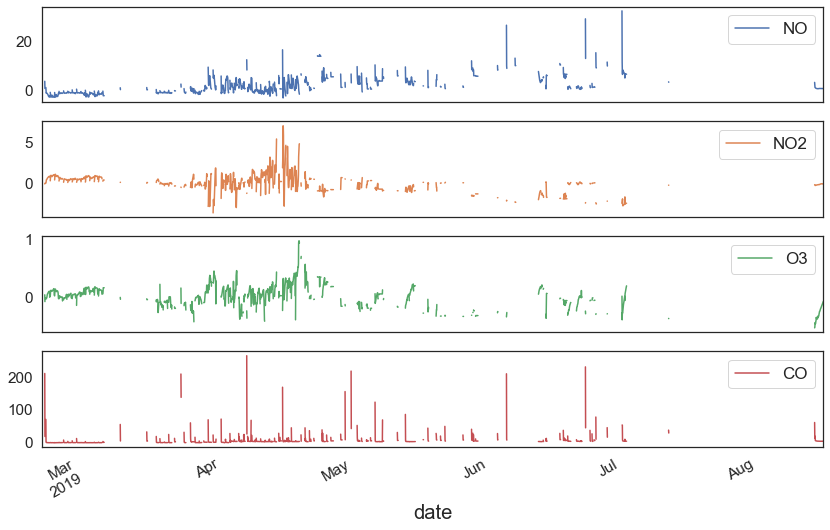

In [26]:
cols_plot = ['NO', 'NO2', 'O3', 'CO']
df.set_index('date')[cols_plot].resample('H').mean().plot(subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_concentration_byHour_1.png')
plt.show()

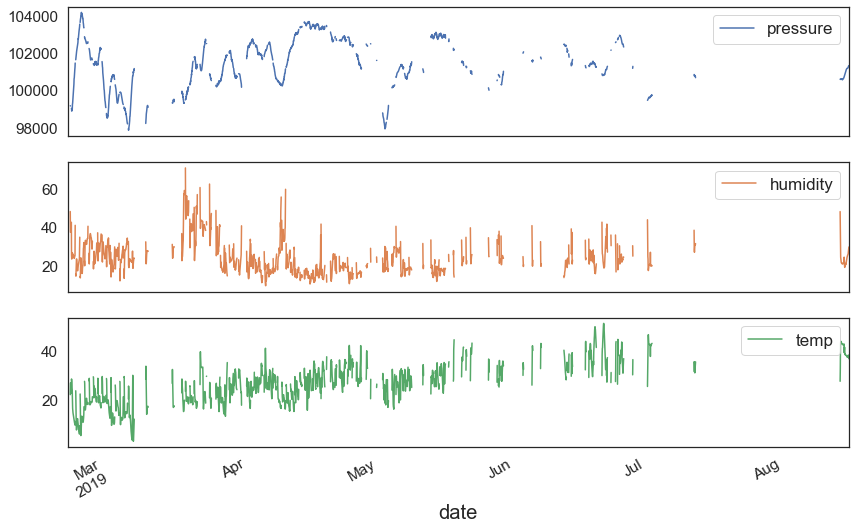

In [27]:
cols_plot_met = ['pressure', 'humidity', 'temp']
df.set_index('date')[cols_plot_met].resample('H').mean().plot(subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_meteorologicalData_byHhour_1.png')
plt.show()

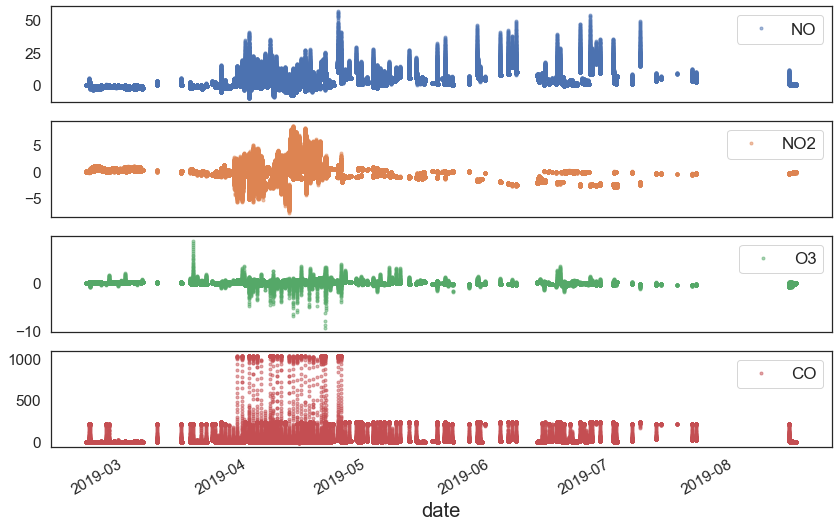

In [28]:
cols_plot = ['NO', 'NO2', 'O3', 'CO']
df.set_index('date')[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_concentration_1.png')

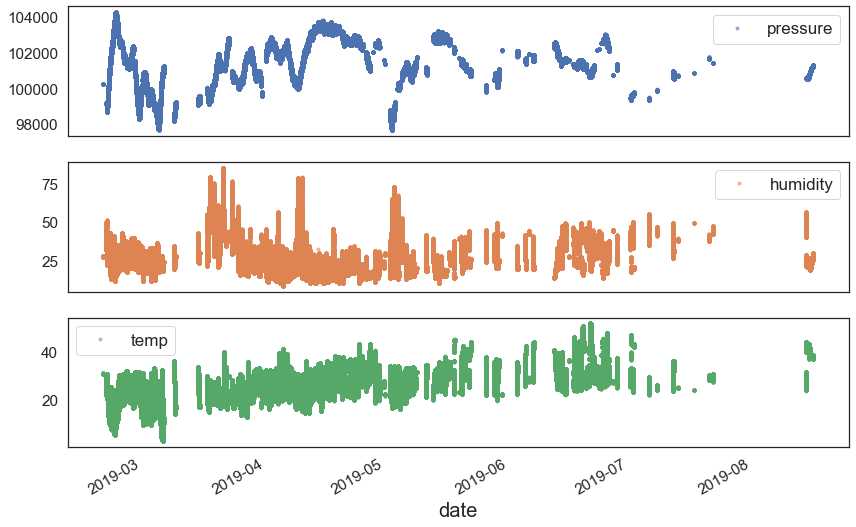

In [29]:
cols_plot_met = ['pressure', 'humidity', 'temp']
df.set_index('date')[cols_plot_met].plot(marker='.', alpha=0.5, linestyle='None', subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_meteorologicalData_1.png')

In [17]:
# Printing summary statistics
desc = df.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc = desc.append(df.reindex(desc.columns, axis=1).agg(['skew', 'kurt']))
desc.to_excel('Final_summary_statistics_1.xlsx')
desc

,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s
count,6052856,6052856,6052856,5095036,5095028,5067860,4986279,6052856,6052856,6052856,1346040,1174500,1872900,650160
mean,2.18,56.86,23.56,1.12,0.08,0.04,0.08,101577.02,22.68,25.75,0.35,0.43,0.04,0.01
std,0.68,13.74,5.69,3.42,1.39,0.21,17.78,1327.14,8.52,8.08,0.32,0.27,0.02,0.00
min,1.00,0.00,0.00,-9.62,-7.74,-9.38,-13.78,97668.00,8.51,3.02,0.00,0.00,0.00,0.00
25%,2.00,60.17,24.92,-1.26,-0.54,-0.08,-3.42,100679.00,16.95,19.73,0.03,0.20,0.02,0.01
50%,2.00,60.18,24.93,0.14,-0.01,0.03,-0.41,101687.00,20.56,25.39,0.23,0.43,0.03,0.01
75%,3.00,60.19,24.95,3.09,0.49,0.14,0.35,102645.00,25.86,31.12,0.65,0.66,0.06,0.01
max,3.00,60.23,24.99,56.63,8.49,8.71,1036.75,104266.00,85.14,51.46,3.56,1.03,0.14,0.02
skew,-0.228503,-3.89521,-3.89514,1.72292,1.47784,0.493397,36.7347,-0.472511,1.58111,0.223709,0.50464,0.0657919,0.261142,-0.00714391
kurt,-0.839961,13.1727,13.1723,5.36425,5.72275,9.50043,1856.62,-0.382219,3.23043,-0.116815,-0.172189,-1.02448,-0.887434,-0.0417164


In [30]:
# Deleting the highest peak e.g 1000 ppm for CO which was cuased due to power on the tram
df.drop(df[df.CO > 50].index, inplace=True)

In [31]:
## Applying background compensation to the whole dataset

In [32]:
# df has a RangeIndex, so we get to slice 
group_size = 3*60
# data frame has been sorted before this point and the rows are in the correct order
slices = df[::group_size]

# but you don't want the group number to be the ordinal at the slices
# so make a copy of the slice to assign good group numbers to it (or get a chained assignment warning)
slices=slices.copy()
slices['group'] = [i for i in range(len(slices))]
df['group'] = slices['group']

# ffill with the nice group numbers
df['group'].ffill(inplace=True)

#now trim the last group
last_group = df['group'].max()
if len(df[df['group']==last_group]) < group_size:
    df = df[df['group'] != last_group]
print(df)

                       date  spora-id   latitude  longitude        NO  \
0       2019-02-19 07:34:09         2  60.184558  24.922632  0.341640   
1       2019-02-19 07:34:10         2  60.184562  24.922633  0.334240   
2       2019-02-19 07:34:11         2  60.184563  24.922632  0.334024   
3       2019-02-19 07:34:12         2  60.184563  24.922638  0.334024   
4       2019-02-19 07:34:13         2  60.184562  24.922643  0.320968   
...                     ...       ...        ...        ...       ...   
6052801 2019-08-16 09:05:24         2   0.000000   0.000000  0.540984   
6052802 2019-08-16 09:05:25         2   0.000000   0.000000  0.509320   
6052803 2019-08-16 09:05:27         2   0.000000   0.000000  0.499336   
6052804 2019-08-16 09:05:27         2   0.000000   0.000000  0.512648   
6052805 2019-08-16 09:05:28         2   0.000000   0.000000  0.510400   

              NO2        O3        CO  pressure  humidity   temp      NO_s  \
0       -0.036944 -0.078952  0.057486  100259

In [33]:
df.group.unique()

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 3.3529e+04, 3.3530e+04,
       3.3531e+04])

In [34]:
# set index of date column
# making dataframe's index as DatetimeIndex, also group column
df.set_index(['date', 'group'], inplace=True)

In [35]:
df.index

MultiIndex([('2019-02-19 07:34:09',     0.0),
            ('2019-02-19 07:34:10',     0.0),
            ('2019-02-19 07:34:11',     0.0),
            ('2019-02-19 07:34:12',     0.0),
            ('2019-02-19 07:34:13',     0.0),
            ('2019-02-19 07:34:14',     0.0),
            ('2019-02-19 07:34:16',     0.0),
            ('2019-02-19 07:34:16',     0.0),
            ('2019-02-19 07:34:17',     0.0),
            ('2019-02-19 07:34:19',     0.0),
            ...
            ('2019-08-16 09:05:19', 33531.0),
            ('2019-08-16 09:05:20', 33531.0),
            ('2019-08-16 09:05:21', 33531.0),
            ('2019-08-16 09:05:22', 33531.0),
            ('2019-08-16 09:05:23', 33531.0),
            ('2019-08-16 09:05:24', 33531.0),
            ('2019-08-16 09:05:25', 33531.0),
            ('2019-08-16 09:05:27', 33531.0),
            ('2019-08-16 09:05:27', 33531.0),
            ('2019-08-16 09:05:28', 33531.0)],
           names=['date', 'group'], length=6035760)

In [36]:
# applying formula for background compensation of the data
back_g = lambda x: x-x.median()
df['NO_b']=df[['NO']].groupby(level='group').transform(back_g)
df['NO2_b']=df[['NO2']].groupby(level='group').transform(back_g)
df['O3_b']=df[['O3']].groupby(level='group').transform(back_g)
df['CO_b']=df[['CO']].groupby(level='group').transform(back_g)
df.head()

,,spora-id,latitude,longitude,NO,NO2,O3,CO,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO_b,NO2_b,O3_b,CO_b
date,group,,,,,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,0.341640,-0.036944,-0.078952,0.057486,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883,-1.044760,0.076608,-0.000790,-0.066464
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,0.334240,-0.042720,-0.078938,0.057486,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883,-1.052160,0.070832,-0.000776,-0.066464
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,0.334024,-0.040896,-0.078902,0.019564,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072656,-0.000739,-0.104386
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,0.334024,-0.041360,-0.079088,0.019564,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072192,-0.000926,-0.104386
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,0.320968,-0.039488,-0.079233,0.172190,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883,-1.065432,0.074064,-0.001070,0.048240


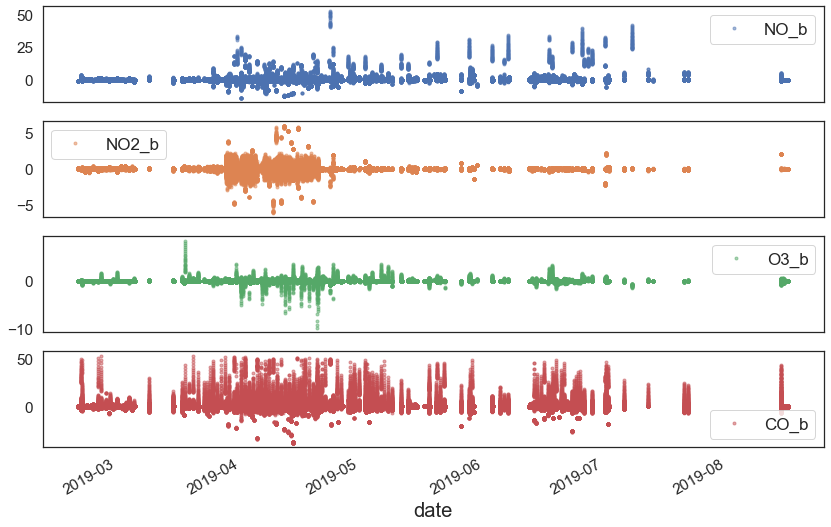

In [37]:
cols_plot_b = ['NO_b', 'NO2_b', 'O3_b', 'CO_b']
df.reset_index('group')[cols_plot_b].plot(marker='.', alpha=0.5, linestyle='None', subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_concentration_b_1.png')

KeyboardInterrupt: 

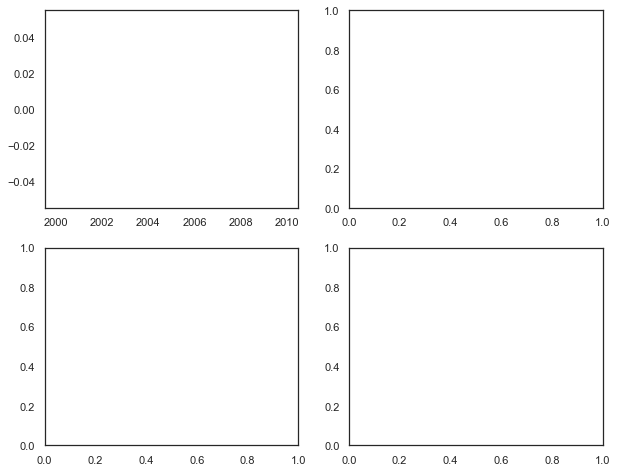

In [218]:
# creating sns sbuplot
# create the time series subplots 
fig,ax =  plt.subplots( 2, 2, 
                       figsize = ( 10, 8)) 
  
sns.lineplot( x = "date", y = "NO",  
             color = 'r', data = df,  
             ax = ax[0][0]) 
  
#ax[0][0].tick_params(labelrotation = 25) 
#https://www.geeksforgeeks.org/creating-a-time-series-plot-with-seaborn-and-pandas/

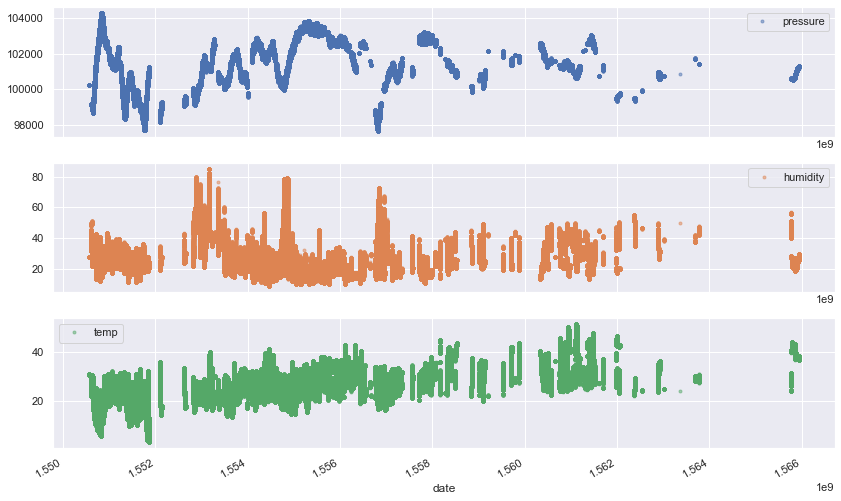

In [24]:
cols_plot_b_met = ['pressure', 'humidity', 'temp']
df.reset_index('group')[cols_plot_b_met].plot(marker='.', alpha=0.5, linestyle='None', subplots=True, legend=True, figsize=(14,9))
plt.savefig('Final_meteorologicalData_b.png')

In [38]:
df = df.drop(['NO', 'NO2', 'O3', 'CO'], axis=1)
df.head()

,,spora-id,latitude,longitude,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO_b,NO2_b,O3_b,CO_b
date,group,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883,-1.044760,0.076608,-0.000790,-0.066464
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883,-1.052160,0.070832,-0.000776,-0.066464
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072656,-0.000739,-0.104386
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072192,-0.000926,-0.104386
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883,-1.065432,0.074064,-0.001070,0.048240


In [39]:
# handling negative value using Polissar method
neg_v = lambda x: x[x>0].mean()/2
df['NO_p']=df[['NO_b']].groupby(level='group').transform(neg_v)
df['NO2_p']=df[['NO2_b']].groupby(level='group').transform(neg_v)
df['O3_p']=df[['O3_b']].groupby(level='group').transform(neg_v)
df['CO_p']=df[['CO_b']].groupby(level='group').transform(neg_v)

df.head()

,,spora-id,latitude,longitude,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO_b,NO2_b,O3_b,CO_b,NO_p,NO2_p,O3_p,CO_p
date,group,,,,,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883,-1.044760,0.076608,-0.000790,-0.066464,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883,-1.052160,0.070832,-0.000776,-0.066464,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072656,-0.000739,-0.104386,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883,-1.052376,0.072192,-0.000926,-0.104386,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883,-1.065432,0.074064,-0.001070,0.048240,0.734471,0.025169,0.019661,11.737139


In [40]:
# I dropped the columns now as I intend to apply this lastly
df= df.drop(['NO_b', 'NO2_b', 'CO_b', 'O3_b'], axis=1)
df.head()

,,spora-id,latitude,longitude,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO_p,NO2_p,O3_p,CO_p
date,group,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139


In [41]:
# reset_index for the 'group' column

In [42]:
print('percentage of negative value: \n', df[df<0].count()/len(df))

percentage of negative value: 
 spora-id     0.0
latitude     0.0
longitude    0.0
pressure     0.0
humidity     0.0
temp         0.0
NO_s         0.0
NO2_s        0.0
O3_s         0.0
CO_s         0.0
NO_p         0.0
NO2_p        0.0
O3_p         0.0
CO_p         0.0
dtype: float64


#### Vizualization of the data

In [43]:
df.rename(columns={'NO_p':'NO', 'NO2_p':'NO2', 'O3_p':'O3', 'CO_p':'CO','pressure':'Pressure', 'humidity':'Humidity', 'temp':'Temperature'}, inplace=True)
df.head()

,,spora-id,latitude,longitude,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO
date,group,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,27.889,30.55,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,27.886,30.56,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,27.876,30.56,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,27.876,30.57,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,27.871,30.57,0.020778,0.047479,0.033345,0.004883,0.734471,0.025169,0.019661,11.737139


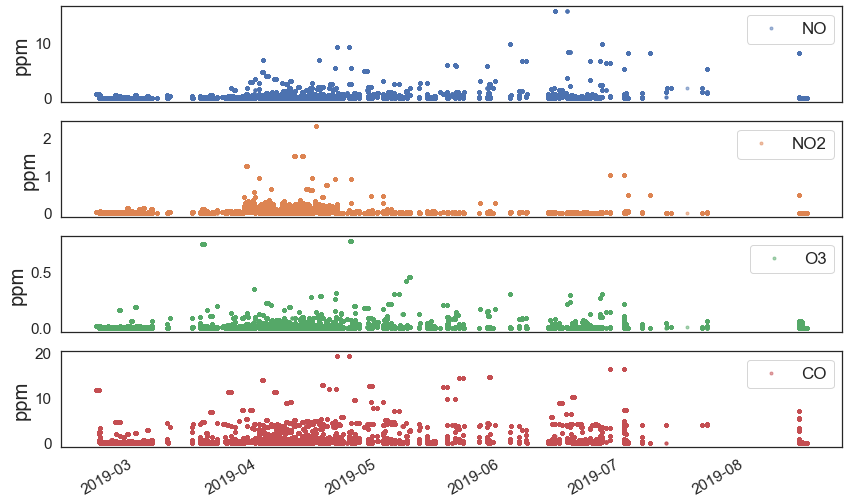

In [45]:
cols_plot = ['NO', 'NO2', 'O3', 'CO']
axes = df.reset_index('group')[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14,9), subplots=True)
for ax in axes:
    ax.set_ylabel('ppm')
    ax.set_xlabel('')
plt.savefig('Final_concentration_after_b_p_1.png')

In [46]:
cols_plot = ['Temperature', 'Humidity', 'Pressure']
axes = df.reset_index('group')[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14,9), subplots=True)
for ax in axes:
    ax.set_ylabel('ppm')
    ax.set_xlabel('')
plt.savefig('Final_concentration_meteoroligical_after_b_p_1.png')

MemoryError: Unable to allocate 599. MiB for an array with shape (13, 6035760) and data type float64

In [47]:
df.isnull().sum()

spora-id             0
latitude             0
longitude            0
Pressure             0
Humidity             0
Temperature          0
NO_s           4690871
NO2_s          4863046
O3_s           4164945
CO_s           5386323
NO             1717920
NO2            1718460
O3             1718820
CO             1719540
dtype: int64

In [39]:
# view the timeseries data in a slider (to detect missing value)

#fig = px.line(df.reset_index('group').resample('H').mean(), y='CO_p', title='CO_p with Slider')

#fig.update_xaxes(
    #rangeslider_visible=True,
    #rangeselector = dict(
        #buttons=list([dict(step='all')]) ))
#fig.show()

In [74]:
# We will took the data from Feb to June as after June there was few data recorded
#df = df.loc['2019-02':'2019-06']
#df.tail()

#### Filling the missing value

In [48]:
# forward filling
#Tuesday data (missing) equals to Monday data (existing) is forward filling. The opposite is backward filling
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

spora-id       0
latitude       0
longitude      0
Pressure       0
Humidity       0
Temperature    0
NO_s           0
NO2_s          0
O3_s           0
CO_s           0
NO             0
NO2            0
O3             0
CO             0
dtype: int64

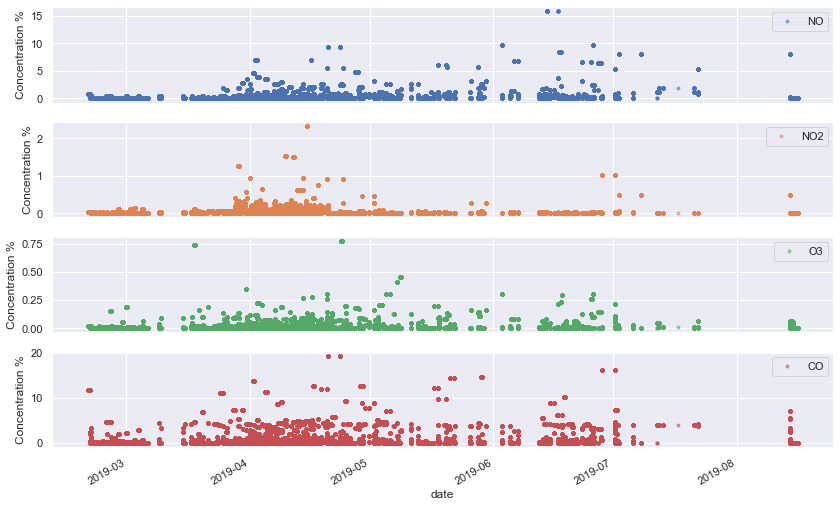

In [44]:
cols_plot = ['NO', 'NO2', 'O3', 'CO']
axes = df.reset_index('group')[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14,9), subplots=True)
for ax in axes:
    ax.set_ylabel('Concentration %')
plt.savefig('Final_concentration_after_b_p_ffill.png')


#### Outlier detection

In [45]:
#finding outliers by running the summary statistics on the variables.
desc = df.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc = desc.append(df.reindex(desc.columns, axis=1).agg(['skew', 'kurt']))
desc.iloc[1:] = desc.iloc[1:].applymap('{:.3f}'.format)
desc.to_excel('Final_summary_statistics_after_b_p_ffill.xlsx')
desc

,spora-id,latitude,longitude,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO
count,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760
mean,2.175,56.928,23.587,101576.977,22.643,25.751,0.111,0.085,0.014,0.011,0.120,0.014,0.005,0.144
std,0.677,13.611,5.640,1327.356,8.487,8.087,0.198,0.207,0.020,0.003,0.638,0.033,0.019,0.534
min,1.000,0.000,0.000,97668.000,8.508,3.020,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.001
25%,2.000,60.168,24.922,100678.000,16.938,19.730,0.025,0.000,0.001,0.011,0.009,0.003,0.000,0.033
50%,2.000,60.182,24.935,101687.000,20.538,25.400,0.055,0.000,0.001,0.012,0.023,0.005,0.001,0.044
75%,3.000,60.193,24.948,102646.000,25.810,31.130,0.055,0.002,0.024,0.012,0.067,0.013,0.002,0.091
max,3.000,60.226,24.988,104266.000,85.144,51.460,3.563,1.026,0.144,0.019,15.880,2.328,0.775,19.350
skew,-0.228,-3.943,-3.943,-0.472,1.580,0.222,2.917,2.527,1.624,-1.537,10.351,22.298,10.593,11.894
kurt,-0.839,13.550,13.549,-0.382,3.208,-0.122,9.168,5.337,1.919,3.384,114.129,1089.077,220.547,220.983


In [51]:
# finding outlier using skewness
df.skew()

spora-id       -0.227899
latitude       -3.943282
longitude      -3.943211
Pressure       -0.472425
Humidity        1.579955
Temperature     0.222123
NO_s            2.917161
NO2_s           2.526733
O3_s            1.624169
CO_s           -1.537155
NO             10.351060
NO2            22.298222
O3             10.593432
CO             11.893735
dtype: float64

In [ ]:
# saving the data at this stage for 
df.to_csv('C:/Users/Rabbil/Documents/BDA_thesis/Notebooks/cleaned_df_b_p_outl.csv')

In [47]:
# the skewness value should be between -1 and +1, 
# and any major deviation from this range indicates the presence of extreme values.

In [50]:
# outlier detection using boxplot
svm=sns.boxplot(df.reset_index('group').resample('H').mean().NO2)
figure= svm.get_figure()
#figure.savefig('boxplot_saving.png')
# as most of our features have outliers, so we will not use mean value for outlier replacement


MemoryError: Unable to allocate 599. MiB for an array with shape (13, 6035760) and data type float64

MemoryError: Unable to allocate 599. MiB for an array with shape (13, 6035760) and data type float64

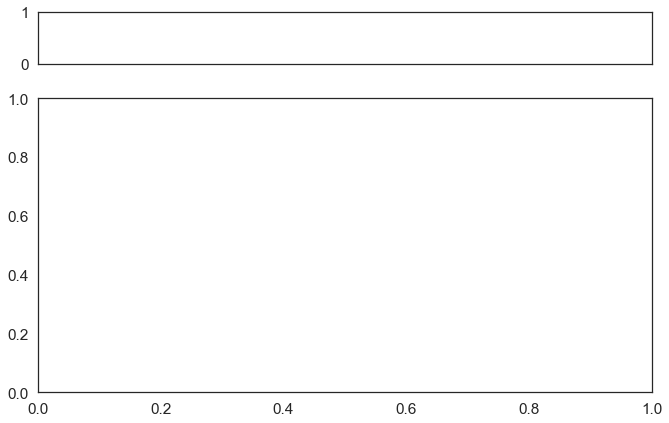

In [49]:
# dist plot and box plot together
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
#sns.boxplot(df["sepal_length"], ax=ax_box)
svm=sns.boxplot(df.reset_index('group').resample('H').mean().NO2, ax=ax_box)
svm=sns.distplot(df.reset_index('group').resample('H').mean().NO2, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

figure= svm.get_figure()
#figure.savefig('boxplot_distplot_NO2.png')

C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


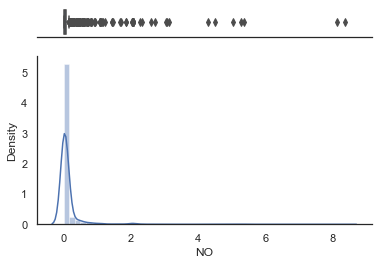

In [50]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
#sns.boxplot(df["sepal_length"], ax=ax_box)
svm=sns.boxplot(df.reset_index('group').resample('H').mean().NO, ax=ax_box)
svm=sns.distplot(df.reset_index('group').resample('H').mean().NO, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

figure= svm.get_figure()
figure.savefig('boxplot_distplot_NO.png')

C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


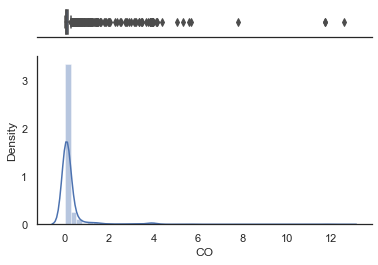

In [51]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
#sns.boxplot(df["sepal_length"], ax=ax_box)
svm=sns.boxplot(df.reset_index('group').resample('H').mean().CO, ax=ax_box)
svm=sns.distplot(df.reset_index('group').resample('H').mean().CO, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

figure= svm.get_figure()
figure.savefig('boxplot_distplot_CO.png')

C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


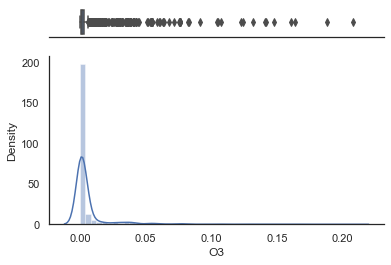

In [52]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
#sns.boxplot(df["sepal_length"], ax=ax_box)
svm=sns.boxplot(df.reset_index('group').resample('H').mean().O3, ax=ax_box)
svm=sns.distplot(df.reset_index('group').resample('H').mean().O3, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

figure= svm.get_figure()
figure.savefig('boxplot_distplot_O3.png')

C:\Users\Rabbil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NO2', ylabel='Density'>

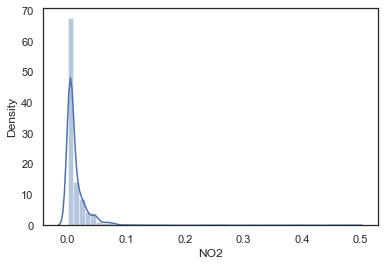

In [53]:
# outlier detection using distplot
sns.distplot(df.reset_index('group').resample('H').mean().NO2)
# However, the features has skewed distribution pattern, so using median value will give good replacement for outliers

In [38]:
# sources: https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
# replacing outliers with median 

print(df['CO'].quantile(0.50)) # prints the 50th percentile value, or the median
print(df['CO'].quantile(0.95)) # prints the 95th percentile value

0.04382585222222219
0.3022191333333335


In [39]:
df['CO_outl'] = np.where(df['CO'] > df['CO'].quantile(0.95), df['CO'].quantile(0.50), df['CO']) # replaces all values, which are > the 95th percentile, with the median value

In [40]:
print(df['NO'].quantile(0.50)) 
print(df['NO'].quantile(0.95)) 

0.023224799999999993
0.18414553846153772


In [41]:
df['NO_outl'] = np.where(df['NO'] > df['NO'].quantile(0.95), df['NO'].quantile(0.50), df['NO'])

In [42]:
print(df['NO2'].quantile(0.50)) 
print(df['NO2'].quantile(0.95)) 

0.0049788088888888925
0.05106529555555554


In [43]:
df['NO2_outl'] = np.where(df['NO2'] > df['NO2'].quantile(0.95), df['NO2'].quantile(0.50), df['NO2'])

In [44]:
print(df['O3'].quantile(0.50)) 
print(df['O3'].quantile(0.95))

0.0008595617777777812
0.011891882222222214


In [45]:
df['O3_outl'] = np.where(df['O3'] > df['O3'].quantile(0.95), df['O3'].quantile(0.95), df['O3'])

In [46]:
print(df['humidity'].quantile(0.50)) 
print(df['humidity'].quantile(0.95))

20.538
40.029


In [47]:
df['humidity_outl'] = np.where(df['humidity'] > df['humidity'].quantile(0.95), df['humidity'].quantile(0.50), df['humidity'])

In [48]:
print(df['temp'].quantile(0.50)) 
print(df['temp'].quantile(0.95))

25.4
40.28


In [49]:
#print(df['temp'].quantile(0.90))

In [52]:
df['temp_outl'] = np.where(df['temp'] > df['temp'].quantile(0.95), df['temp'].quantile(0.50), df['temp'])

MemoryError: Unable to allocate 46.0 MiB for an array with shape (1, 6035760) and data type float64

In [71]:
# Now checking the distribution of data
desc = df.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc = desc.append(df.reindex(desc.columns, axis=1).agg(['skew', 'kurt']))
desc.iloc[1:] = desc.iloc[1:].applymap('{:.3f}'.format)
desc.to_excel('Final_summary_statistics_after_b_p_ffill_outl.xlsx')
desc

,spora-id,latitude,longitude,pressure,humidity,temp,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO,CO_outl,NO_outl,NO2_outl,O3_outl,humidity_outl,temp_outl
count,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760,6035760
mean,2.175,56.928,23.587,101576.977,22.643,25.751,0.111,0.085,0.014,0.011,0.120,0.014,0.005,0.144,0.069,0.036,0.009,0.002,21.297,24.854
std,0.677,13.611,5.640,1327.356,8.487,8.087,0.198,0.207,0.020,0.003,0.638,0.033,0.019,0.534,0.062,0.039,0.010,0.003,6.142,6.986
min,1.000,0.000,0.000,97668.000,8.508,3.020,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.001,0.001,0.002,0.000,0.000,8.508,3.020
25%,2.000,60.168,24.922,100678.000,16.938,19.730,0.025,0.000,0.001,0.011,0.009,0.003,0.000,0.033,0.033,0.009,0.003,0.000,16.938,19.730
50%,2.000,60.182,24.935,101687.000,20.538,25.400,0.055,0.000,0.001,0.012,0.023,0.005,0.001,0.044,0.044,0.023,0.005,0.001,20.538,25.400
75%,3.000,60.193,24.948,102646.000,25.810,31.130,0.055,0.002,0.024,0.012,0.067,0.013,0.002,0.091,0.074,0.053,0.010,0.002,24.529,29.820
max,3.000,60.226,24.988,104266.000,85.144,51.460,3.563,1.026,0.144,0.019,15.880,2.328,0.775,19.350,0.302,0.184,0.051,0.012,40.029,40.280
skew,-0.228,-3.943,-3.943,-0.472,1.580,0.222,2.917,2.527,1.624,-1.537,10.351,22.298,10.593,11.894,1.854,1.768,2.134,2.684,0.854,-0.122
kurt,-0.839,13.550,13.549,-0.382,3.208,-0.122,9.168,5.337,1.919,3.384,114.129,1089.077,220.547,220.983,2.503,2.951,4.237,6.698,0.495,-0.303


In [51]:
df= df.drop(['humidity', 'NO', 'NO2','CO', 'O3'], axis=1)
df.head()

MemoryError: Unable to allocate 875. MiB for an array with shape (19, 6035760) and data type float64

In [84]:
df= df.drop(['temp'], axis=1)
df.head()

,,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO_outl,NO_outl,NO2_outl,O3_outl,humidity_outl,temp_outl
date,group,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.889,30.55
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.886,30.56
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.56
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.57
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.871,30.57


In [85]:
df.rename(columns={'humidity_outl': 'humidity', 'temp_outl': 'temp','CO_outl':'CO', 'NO_outl':'NO', 'NO2_outl':'NO2', 'O3_outl':'O3'}, inplace=True)
df.head()

,,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp
date,group,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.889,30.55
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.886,30.56
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.56
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.57
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.871,30.57


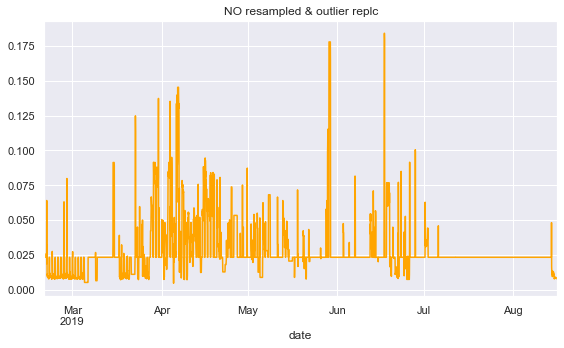

In [49]:
# vizualization of the data after outlier replacement with median and performing resmaple
df.reset_index('group').NO.resample('H').mean().fillna(df.NO.median()).plot(title='NO resampled & outlier replc', color='orange') 
plt.tight_layout()
plt.show()



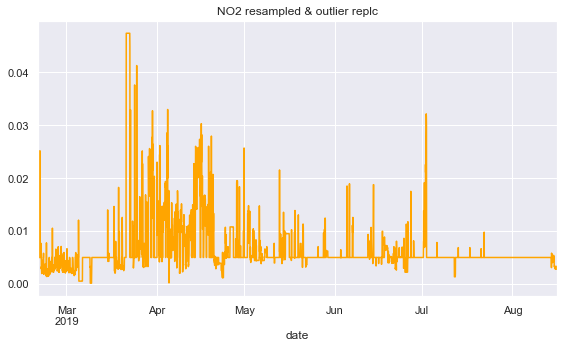

In [50]:
df.reset_index('group').NO2.resample('H').mean().fillna(df.NO2.median()).plot(title='NO2 resampled & outlier replc', color='orange') 
plt.tight_layout()
plt.show()

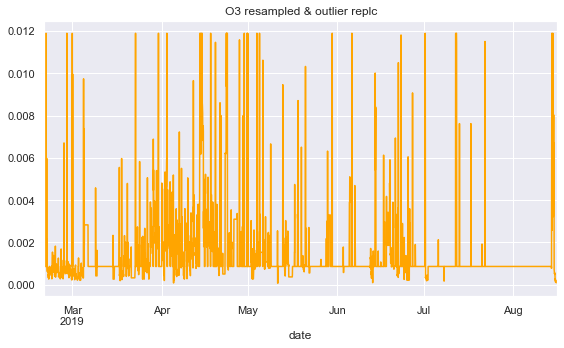

In [51]:
df.reset_index('group').O3.resample('H').mean().fillna(df.O3.median()).plot(title='O3 resampled & outlier replc', color='orange') 
plt.tight_layout()
plt.show()

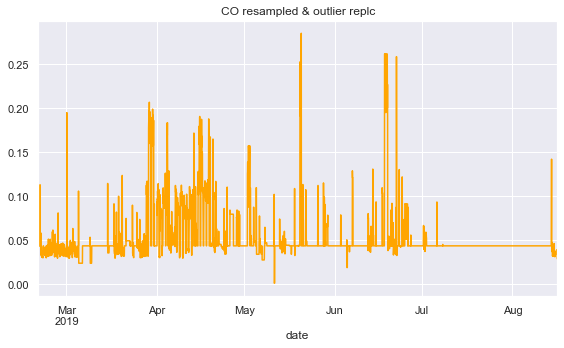

In [52]:
df.reset_index('group').CO.resample('H').mean().fillna(df.CO.median()).plot(title='CO resampled & outlier replc', color='orange') 
plt.tight_layout()
plt.show()

In [53]:
# Based on these plots above, it is clear that data upto June 30 would be good for prediction plot as there is few spikes

#### resampling method

In [86]:
df =df.reset_index('group')
df.head()

,group,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp
date,,,,,,,,,,,,,,,
2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.889,30.55
2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.886,30.56
2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.56
2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.57
2019-02-19 07:34:13,0.0,2,60.184562,24.922643,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.871,30.57


In [87]:
df= df.drop(['group'], axis=1)
df.head()

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp
date,,,,,,,,,,,,,,
2019-02-19 07:34:09,2,60.184558,24.922632,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.889,30.55
2019-02-19 07:34:10,2,60.184562,24.922633,100259.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.886,30.56
2019-02-19 07:34:11,2,60.184563,24.922632,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.56
2019-02-19 07:34:12,2,60.184563,24.922638,100261.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.876,30.57
2019-02-19 07:34:13,2,60.184562,24.922643,100260.0,0.020778,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.871,30.57


In [88]:
# saving the data at this stage (before feature engineering)- this data can be used for geospatial plotting
df.to_csv('C:/Users/Rabbil/Documents/BDA_thesis/Notebooks/cleaned_df_b_p_outl.csv')

In [89]:
# resmaple to hourly frequency, aggregating with mean
df_by_hour = df.resample('H').mean()
print(df_by_hour.head())
print(df_by_hour.shape)

                     spora-id   latitude  longitude       pressure      NO_s  \
date                                                                           
2019-02-19 07:00:00       2.0  60.184556  24.922704  100256.183908  0.020777   
2019-02-19 08:00:00       NaN        NaN        NaN            NaN       NaN   
2019-02-19 09:00:00       NaN        NaN        NaN            NaN       NaN   
2019-02-19 10:00:00       NaN        NaN        NaN            NaN       NaN   
2019-02-19 11:00:00       NaN        NaN        NaN            NaN       NaN   

                        NO2_s      O3_s      CO_s        CO        NO  \
date                                                                    
2019-02-19 07:00:00  0.047479  0.033345  0.004883  0.043826  0.023225   
2019-02-19 08:00:00       NaN       NaN       NaN       NaN       NaN   
2019-02-19 09:00:00       NaN       NaN       NaN       NaN       NaN   
2019-02-19 10:00:00       NaN       NaN       NaN       NaN       NaN   
2

In [92]:
df_by_hour.fillna(method='ffill', inplace=True)
df_by_hour.isnull().sum()

spora-id     0
latitude     0
longitude    0
pressure     0
NO_s         0
NO2_s        0
O3_s         0
CO_s         0
CO           0
NO           0
NO2          0
O3           0
humidity     0
temp         0
dtype: int64

#### Feature Engineering

##### Temporal feature engineering 

In [95]:
# Feature engineering with timestamp data
# Extracting year, month and day information
# We can do it easily as DatetimeIndex has individual attributes for year, month, day etc

# Add columns with year, month, day and weeday name
df_by_hour['Hour'] = df_by_hour.index.hour
df_by_hour['Day_of_week'] = df_by_hour.index.dayofweek
df_by_hour['Day_of_month'] = df_by_hour.index.day
df_by_hour['Month'] = df_by_hour.index.month
df_by_hour['Day'] = df_by_hour.index.day_name()

df_by_hour.head()

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp,Hour,Day_of_week,Day_of_month,Month,Day
date,,,,,,,,,,,,,,,,,,,
2019-02-19 07:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,7,1,19,2,Tuesday
2019-02-19 08:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,8,1,19,2,Tuesday
2019-02-19 09:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,9,1,19,2,Tuesday
2019-02-19 10:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,10,1,19,2,Tuesday
2019-02-19 11:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,11,1,19,2,Tuesday


In [96]:
# create the feature of 'is_weekday' from Day column
# Defining the day as weekday (1) or weekend (0)
filter1 = df_by_hour['Day']== 'Saturday'
filter2 = df_by_hour['Day']== 'Sunday'

df_by_hour['is_weekday']= np.where(filter1 | filter2, 0, 1)

df_by_hour.head(2)

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp,Hour,Day_of_week,Day_of_month,Month,Day,is_weekday
date,,,,,,,,,,,,,,,,,,,,
2019-02-19 07:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,7,1,19,2,Tuesday,1
2019-02-19 08:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,0.025169,0.011892,27.662287,30.718736,8,1,19,2,Tuesday,1


In [97]:
# let's see the value for Saturday and Sunday
df_by_hour.query("Day=='Saturday' or Day =='Sunday'")

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,NO2,O3,humidity,temp,Hour,Day_of_week,Day_of_month,Month,Day,is_weekday
date,,,,,,,,,,,,,,,,,,,,
2019-02-23 00:00:00,2.0,60.184136,24.923032,103344.438625,0.020778,0.287926,0.049092,0.011179,0.032728,0.009383,0.002928,0.000532,31.638071,17.365638,0,5,23,2,Saturday,0
2019-02-23 01:00:00,2.0,60.184136,24.923032,103344.438625,0.020778,0.287926,0.049092,0.011179,0.032728,0.009383,0.002928,0.000532,31.638071,17.365638,1,5,23,2,Saturday,0
2019-02-23 02:00:00,2.0,60.184136,24.923032,103344.438625,0.020778,0.287926,0.049092,0.011179,0.032728,0.009383,0.002928,0.000532,31.638071,17.365638,2,5,23,2,Saturday,0
2019-02-23 03:00:00,2.0,60.194026,24.909584,102866.745153,0.020778,0.280434,0.046430,0.011179,0.042919,0.011874,0.004614,0.001821,22.471065,27.619576,3,5,23,2,Saturday,0
2019-02-23 04:00:00,2.0,60.181727,24.923881,102788.385833,0.020777,0.265624,0.045248,0.011179,0.035694,0.008661,0.002537,0.000377,19.930814,26.889494,4,5,23,2,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-11 19:00:00,2.0,52.112720,21.610988,101416.284404,0.055463,0.000352,0.001295,0.011830,0.043826,0.023225,0.009770,0.011504,20.538000,29.534128,19,6,11,8,Sunday,0
2019-08-11 20:00:00,2.0,52.112720,21.610988,101416.284404,0.055463,0.000352,0.001295,0.011830,0.043826,0.023225,0.009770,0.011504,20.538000,29.534128,20,6,11,8,Sunday,0
2019-08-11 21:00:00,2.0,52.112720,21.610988,101416.284404,0.055463,0.000352,0.001295,0.011830,0.043826,0.023225,0.009770,0.011504,20.538000,29.534128,21,6,11,8,Sunday,0


In [63]:
# Day part
# creating six groups of daypart on Hour column
# daypart function
#def daypart(hour):
    if hour in [2,3,4,5]:
        return "dawn"
    elif hour in [6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"
# utilize it along with apply method
df_by_hour['daypart'] = df_by_hour.Hour.apply(daypart)


In [98]:
# Day part
# creating four groups of daypart on Hour column
# daypart function
def daypart(hour):
    if hour in [4,5,6,7,8,9]:
        return "Morning"
    elif hour in [10,11,12,13,14,15]:
        return "Noon"
    elif hour in [16,17,18,19,20,21]:
        return "Evening"
    else: return "Night"
# utilize it along with apply method
df_by_hour['daypart'] = df_by_hour.Hour.apply(daypart)

In [99]:
# converting categorical variable into numerical
# alternate option: train['city'] = train['city'].astype('category').cat.codes
df_by_hour['daypart'] = pd.factorize(df_by_hour.daypart)[0]

In [100]:
df_by_hour.head()

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,O3,humidity,temp,Hour,Day_of_week,Day_of_month,Month,Day,is_weekday,daypart
date,,,,,,,,,,,,,,,,,,,,,
2019-02-19 07:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,...,0.011892,27.662287,30.718736,7,1,19,2,Tuesday,1,0
2019-02-19 08:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,...,0.011892,27.662287,30.718736,8,1,19,2,Tuesday,1,0
2019-02-19 09:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,...,0.011892,27.662287,30.718736,9,1,19,2,Tuesday,1,0
2019-02-19 10:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,...,0.011892,27.662287,30.718736,10,1,19,2,Tuesday,1,1
2019-02-19 11:00:00,2.0,60.184556,24.922704,100256.183908,0.020777,0.047479,0.033345,0.004883,0.043826,0.023225,...,0.011892,27.662287,30.718736,11,1,19,2,Tuesday,1,1


In [219]:
# creating season
def season(month):
    if month in [2,3,4]:
        return "Spring"
    else: return "Summer"
# utilize it along with apply method
df_by_hour['Season'] = df_by_hour.Month.apply(season)


In [220]:
# converting categorical variable into numerical
# alternate option: train['city'] = train['city'].astype('category').cat.codes
df_by_hour['Season'] = pd.factorize(df_by_hour.Season)[0]

In [221]:
df_by_hour.tail()

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std,Season
date,,,,,,,,,,,,,,,,,,,,,
2019-08-16 05:00:00,2.0,0.0,0.0,101233.111111,0.055463,0.000351,0.001295,0.01183,0.036728,0.007853,...,0.000092,0.048109,0.00977,0.142284,0.011892,0.007558,0.003026,0.011882,0.003570,1
2019-08-16 06:00:00,2.0,0.0,0.0,101263.486389,0.055463,0.000351,0.001295,0.01183,0.038194,0.008059,...,0.000092,0.048109,0.00977,0.142284,0.011892,0.007580,0.003028,0.011888,0.003624,1
2019-08-16 07:00:00,2.0,0.0,0.0,101287.216944,0.055463,0.000351,0.001295,0.01183,0.035453,0.008107,...,0.000092,0.048109,0.00977,0.142284,0.011892,0.007597,0.003033,0.011907,0.003677,1
2019-08-16 08:00:00,2.0,0.0,0.0,101307.645833,0.055463,0.000351,0.001295,0.01183,0.034294,0.008205,...,0.000092,0.048109,0.00977,0.142284,0.011892,0.007609,0.003034,0.011932,0.003728,1
2019-08-16 09:00:00,2.0,0.0,0.0,101319.714286,0.055463,0.000352,0.001295,0.01183,0.029159,0.007840,...,0.000092,0.048109,0.00977,0.142284,0.011892,0.007621,0.003036,0.012002,0.003778,1


#### Vizualizing the data after feature engineering
- Let's see how our feature engineering effort work, how well the new features separate the data

<AxesSubplot:xlabel='Month', ylabel='NO'>

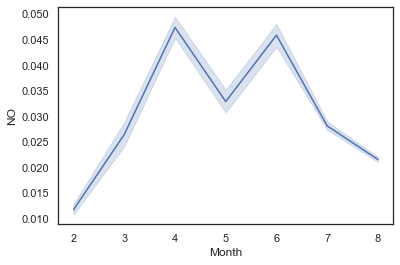

In [101]:
#df_by_month = df_by_hour.resample('M').mean()
#sns.lineplot(x=df_by_month.index, y='O3', data=df_by_month)

# Monthly pattern of data
sns.lineplot(x='Month', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Hour', ylabel='NO'>

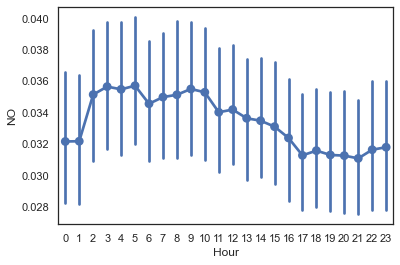

In [102]:
# Hourly pattern of data
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Day_of_week', ylabel='NO'>

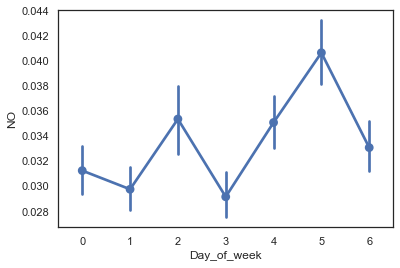

In [103]:
# Day of week pattern 
sns.pointplot(x='Day_of_week', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Hour', ylabel='NO'>

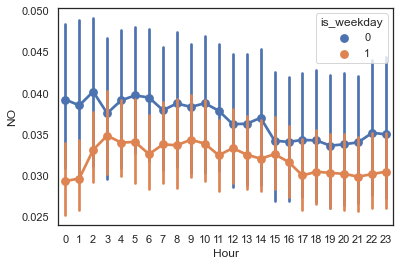

In [104]:
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill(), hue='is_weekday')

<AxesSubplot:xlabel='Hour', ylabel='NO'>

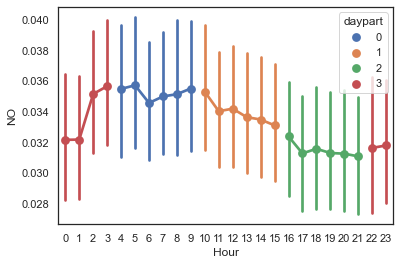

In [105]:
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill(), hue='daypart')

<AxesSubplot:xlabel='Month', ylabel='O3'>

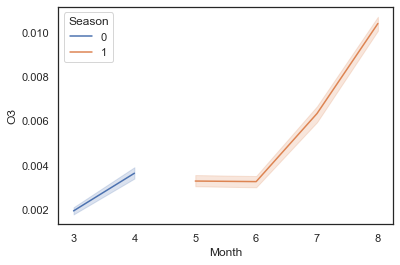

In [222]:
sns.lineplot(x='Month', y='O3', hue='Season', data=df_by_hour.ffill())

##### Statistical feature engineering

In [70]:
# autocorrelation for determining the lag number 
# ref: https://www.youtube.com/watch?v=MmC4b7gPY0Q&t=700s&ab_channel=DataScienceTutorials

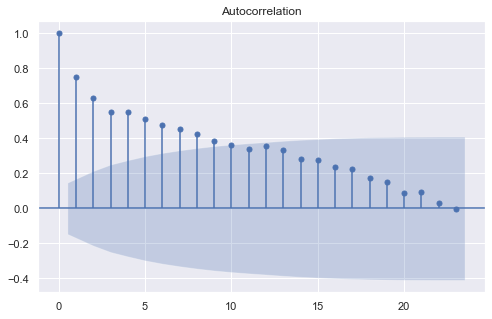

In [71]:
# plot_acf is to idenfify parameter for moving average 
plot_acf(df_by_hour.resample('D').mean().ffill().O3)# to identify the value of moving average
# we choosed 5 day rolling mean or 120 hour rolling mean
# however, for o3 it should be 10 days
plt.savefig('autoC_O3.png')

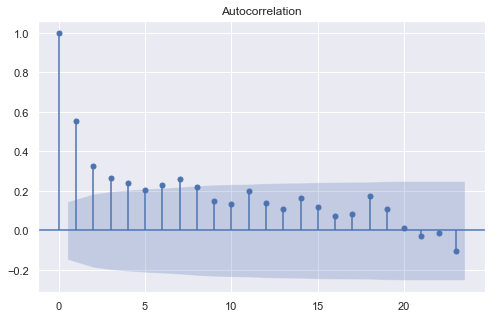

In [73]:
# plot_acf is to idenfify parameter for moving average 
plot_acf(df_by_hour.resample('D').mean().ffill().CO)# to identify the value of moving average
# we choosed 5 day rolling mean or 120 hour rolling mean
# however, for o3 it should be 10 days
plt.savefig('autoC_CO.png')

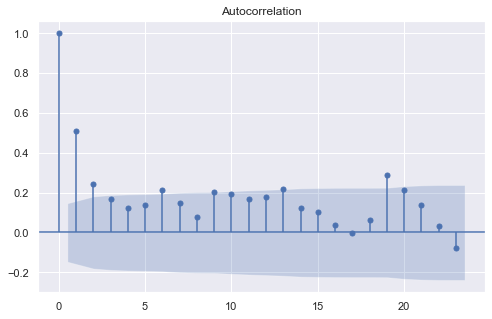

In [74]:
# plot_acf is to idenfify parameter for moving average 
plot_acf(df_by_hour.resample('D').mean().ffill().NO)# to identify the value of moving average
# we choosed 5 day rolling mean or 120 hour rolling mean
# however, for o3 it should be 10 days
plt.savefig('autoC_NO.png')

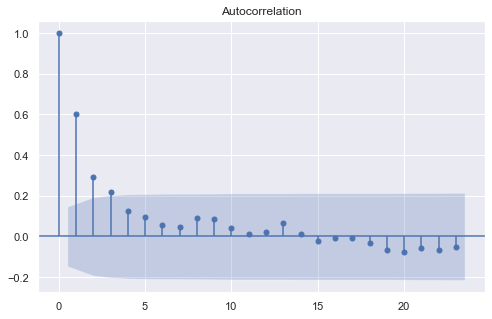

In [75]:
# plot_acf is to idenfify parameter for moving average 
plot_acf(df_by_hour.resample('D').mean().ffill().NO2)# to identify the value of moving average
# we choosed 5 day rolling mean or 120 hour rolling mean
# however, for o3 it should be 10 days
plt.savefig('autoC_NO2.png')

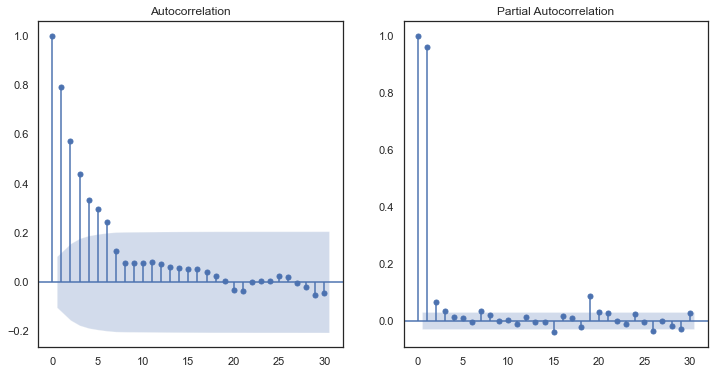

In [123]:
import statsmodels.api as sm
import matplotlib.patches as mpatches # for manually adding legend

fig, ax = plt.subplots(1,2, figsize=(12,6))
sm.graphics.tsa.plot_acf(df_by_hour.resample('12H').mean().ffill().NO2, lags=30, ax=ax[0])


sm.graphics.tsa.plot_pacf(df_by_hour.resample('H').mean().ffill().NO2, lags=30,ax=ax[1])

#3patch = mpatches.Patch(label='NO2')
#plt.legend(handles=[patch])

plt.savefig('autocorelation_partial_NO2')
plt.show()

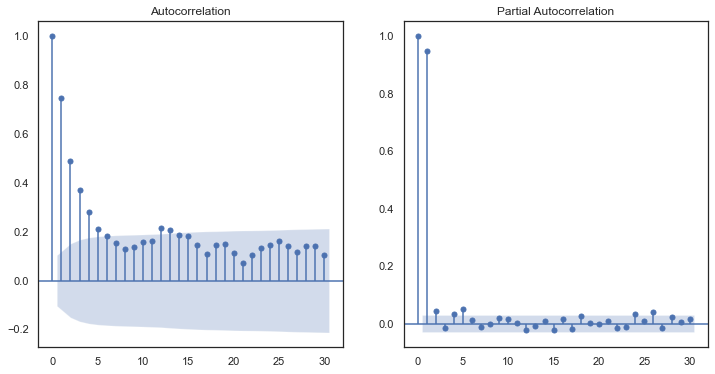

In [124]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sm.graphics.tsa.plot_acf(df_by_hour.resample('12H').mean().ffill().NO,lags=30, ax=ax[0])

sm.graphics.tsa.plot_pacf(df_by_hour.resample('H').mean().ffill().NO,lags=30, ax=ax[1])

plt.savefig('autocorelation_partial_NO')
plt.show()

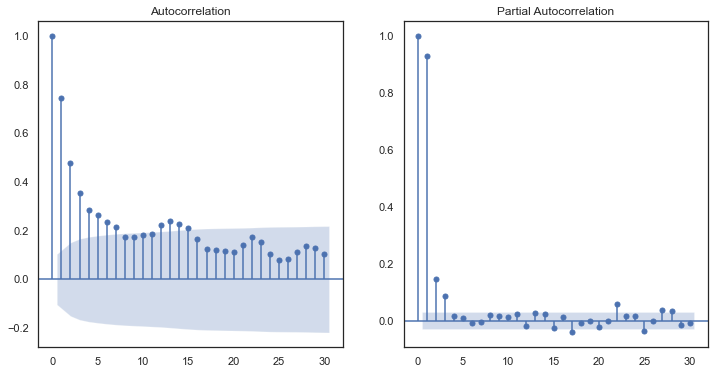

In [125]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sm.graphics.tsa.plot_acf(df_by_hour.resample('12H').mean().ffill().CO,lags=30, ax=ax[0])

sm.graphics.tsa.plot_pacf(df_by_hour.resample('H').mean().ffill().CO,lags=30, ax=ax[1])

plt.savefig('autocorelation_partial_CO')
plt.show()

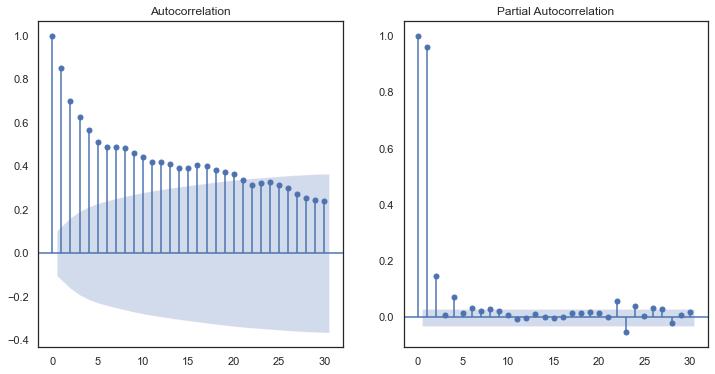

In [126]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sm.graphics.tsa.plot_acf(df_by_hour.resample('12H').mean().ffill().O3,lags=30, ax=ax[0])

sm.graphics.tsa.plot_pacf(df_by_hour.resample('H').mean().ffill().O3,lags=30, ax=ax[1])

plt.savefig('autocorelation_partial_O3')
plt.show()

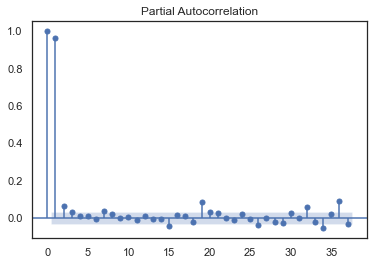

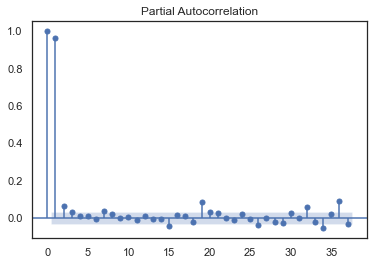

In [127]:
plot_pacf(df_by_hour.ffill().NO2) # to identify the value of autoregression (lag number)
# we see that after 4 observation there is no corelation (which is in critical level) so we seletct order of 4 or 5 

In [85]:
# so we found the lag value differnece as 7 for NO, NO2, 8 for CO, 20 for o3 (x12) ; however that of pacf is 4 hours for all concentrations

In [129]:
df_by_hour.isnull().sum()

spora-id        0
latitude        0
longitude       0
pressure        0
NO_s            0
NO2_s           0
O3_s            0
CO_s            0
CO              0
NO              0
NO2             0
O3              0
humidity        0
temp            0
Hour            0
Day_of_week     0
Day_of_month    0
Month           0
Day             0
is_weekday      0
daypart         0
dtype: int64

In [130]:
#df_by_hour.fillna(method='ffill', inplace=True)
#df_by_hour.isnull().sum()

In [131]:
# creating more feautres based on lagged value difference 
df_by_hour['NO_lag_feature']= df_by_hour.NO.shift(4)
df_by_hour['NO2_lag_feature']= df_by_hour.NO2.shift(4)
df_by_hour['CO_lag_feature']= df_by_hour.CO.shift(4)
df_by_hour['O3_lag_feature']= df_by_hour.O3.shift(4)

In [132]:
# creating more features based on rolling mean
df_by_hour['NO_rolling_mean']= df_by_hour.NO.rolling(window=84).mean()
df_by_hour['NO2_rolling_mean']= df_by_hour.NO2.rolling(window=84).mean()
df_by_hour['CO_rolling_mean']= df_by_hour.CO.rolling(window=96).mean()
df_by_hour['O3_rolling_mean']= df_by_hour.O3.rolling(window=240).mean()

In [133]:
# creating more features based on rolling min
df_by_hour['NO_rolling_min']= df_by_hour.NO.rolling(window=84).min()
df_by_hour['NO2_rolling_min']= df_by_hour.NO2.rolling(window=84).min()
df_by_hour['CO_rolling_min']= df_by_hour.CO.rolling(window=96).min()
df_by_hour['O3_rolling_min']= df_by_hour.O3.rolling(window=240).min()

In [134]:
# creating more features based on rolling max
df_by_hour['NO_rolling_max']= df_by_hour.NO.rolling(window=84).max()
df_by_hour['NO2_rolling_max']= df_by_hour.NO2.rolling(window=84).max()
df_by_hour['CO_rolling_max']= df_by_hour.CO.rolling(window=96).max()
df_by_hour['O3_rolling_max']= df_by_hour.O3.rolling(window=240).max()

In [135]:
# creating more features based on rolling deviation 
df_by_hour['NO_rolling_std']= df_by_hour.NO.rolling(window=84).std()
df_by_hour['NO2_rolling_std']= df_by_hour.NO2.rolling(window=84).std()
df_by_hour['CO_rolling_std']= df_by_hour.CO.rolling(window=96).std()
df_by_hour['O3_rolling_std']= df_by_hour.O3.rolling(window=240).std()

In [203]:
df_by_hour.head(4)

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std,Season
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,2.0,60.166311,24.936104,100619.981389,0.070114,0.000004,0.059470,0.013797,0.032472,0.010423,...,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126,0
2019-03-01 07:00:00,2.0,60.183847,24.937203,100585.411944,0.053840,0.000004,0.059184,0.008911,0.032613,0.009536,...,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055,0
2019-03-01 08:00:00,2.0,60.184016,24.926166,100646.132500,0.043692,0.000004,0.059914,0.010886,0.031223,0.010660,...,0.000218,0.079813,0.007066,0.195127,0.011892,0.010113,0.001182,0.017392,0.002983,0
2019-03-01 09:00:00,2.0,60.174576,24.939602,100738.212500,0.046430,0.000004,0.062034,0.008726,0.034489,0.008446,...,0.000218,0.079813,0.007066,0.195127,0.011892,0.010109,0.001179,0.017394,0.002907,0


In [137]:
df_by_hour.isnull().sum()

spora-id              0
latitude              0
longitude             0
pressure              0
NO_s                  0
NO2_s                 0
O3_s                  0
CO_s                  0
CO                    0
NO                    0
NO2                   0
O3                    0
humidity              0
temp                  0
Hour                  0
Day_of_week           0
Day_of_month          0
Month                 0
Day                   0
is_weekday            0
daypart               0
NO_lag_feature        4
NO2_lag_feature       4
CO_lag_feature        4
O3_lag_feature        4
NO_rolling_mean      83
NO2_rolling_mean     83
CO_rolling_mean      95
O3_rolling_mean     239
NO_rolling_min       83
NO2_rolling_min      83
CO_rolling_min       95
O3_rolling_min      239
NO_rolling_max       83
NO2_rolling_max      83
CO_rolling_max       95
O3_rolling_max      239
NO_rolling_std       83
NO2_rolling_std      83
CO_rolling_std       95
O3_rolling_std      239
dtype: int64

In [138]:
# we are now dropping the first rows with null value which is added after feature added
df_by_hour =df_by_hour.dropna()
# For filling with median
#df_by_hour = df_by_hour.fillna(df.median())
# for filling with zeros
#df_by_hour.fillna(0.00, index =True)
df_by_hour.head()


,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,2.0,60.166311,24.936104,100619.981389,0.070114,0.000004,0.059470,0.013797,0.032472,0.010423,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,2.0,60.183847,24.937203,100585.411944,0.053840,0.000004,0.059184,0.008911,0.032613,0.009536,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055
2019-03-01 08:00:00,2.0,60.184016,24.926166,100646.132500,0.043692,0.000004,0.059914,0.010886,0.031223,0.010660,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010113,0.001182,0.017392,0.002983
2019-03-01 09:00:00,2.0,60.174576,24.939602,100738.212500,0.046430,0.000004,0.062034,0.008726,0.034489,0.008446,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010109,0.001179,0.017394,0.002907
2019-03-01 10:00:00,2.0,60.183602,24.938664,100714.370000,0.051988,0.000004,0.063415,0.008813,0.035262,0.009158,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010114,0.001180,0.017392,0.002829


In [204]:
df_by_hour.shape

(4036, 42)

In [140]:
df_by_hour.isnull().sum()

spora-id            0
latitude            0
longitude           0
pressure            0
NO_s                0
NO2_s               0
O3_s                0
CO_s                0
CO                  0
NO                  0
NO2                 0
O3                  0
humidity            0
temp                0
Hour                0
Day_of_week         0
Day_of_month        0
Month               0
Day                 0
is_weekday          0
daypart             0
NO_lag_feature      0
NO2_lag_feature     0
CO_lag_feature      0
O3_lag_feature      0
NO_rolling_mean     0
NO2_rolling_mean    0
CO_rolling_mean     0
O3_rolling_mean     0
NO_rolling_min      0
NO2_rolling_min     0
CO_rolling_min      0
O3_rolling_min      0
NO_rolling_max      0
NO2_rolling_max     0
CO_rolling_max      0
O3_rolling_max      0
NO_rolling_std      0
NO2_rolling_std     0
CO_rolling_std      0
O3_rolling_std      0
dtype: int64

In [205]:
df_by_hour.columns

Index(['spora-id', 'latitude', 'longitude', 'pressure', 'NO_s', 'NO2_s',
       'O3_s', 'CO_s', 'CO', 'NO', 'NO2', 'O3', 'humidity', 'temp', 'Hour',
       'Day_of_week', 'Day_of_month', 'Month', 'Day', 'is_weekday', 'daypart',
       'NO_lag_feature', 'NO2_lag_feature', 'CO_lag_feature', 'O3_lag_feature',
       'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
       'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
       'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
       'CO_rolling_max', 'O3_rolling_max', 'NO_rolling_std', 'NO2_rolling_std',
       'CO_rolling_std', 'O3_rolling_std', 'Season'],
      dtype='object')

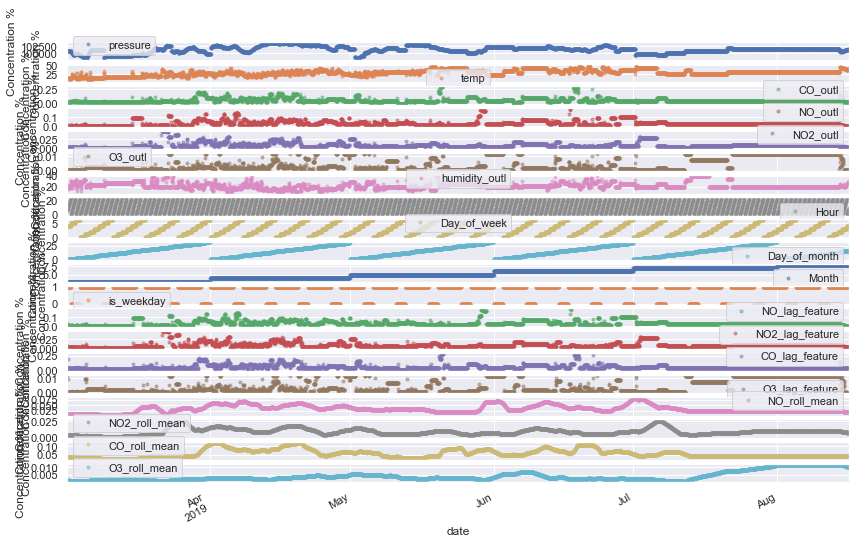

In [98]:
# plotting all the features
# dot plot
#cols_plot = ['pressure', 'temp', 'CO_outl', 'NO_outl', 'NO2_outl', 'O3_outl',
       'humidity_outl', 'Hour', 'Day_of_week', 'Day_of_month', 'Month', 'Day',
       'is_weekday', 'NO_lag_feature', 'NO2_lag_feature', 'CO_lag_feature',
       'O3_lag_feature', 'NO_roll_mean', 'NO2_roll_mean', 'CO_roll_mean',
       'O3_roll_mean']
#axes = df_by_hour[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14,9), subplots=True)
3for ax in axes:
    #ax.set_ylabel('Concentration %')
# df_by_hour[cols_plot].plot(subplots=True)

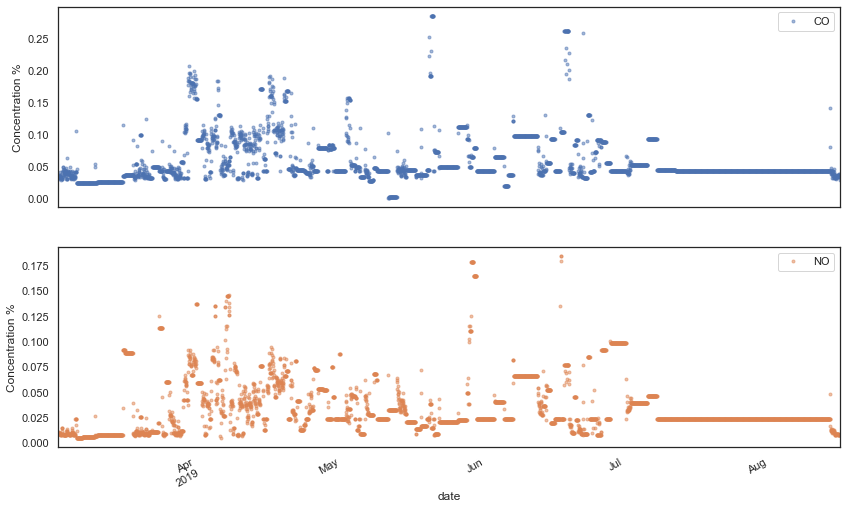

In [217]:
cols_plot = ['CO', 'NO']
axes = df_by_hour[cols_plot].plot(marker='.', alpha=0.5, linestyle='None',figsize=(14,9), subplots=True)
for ax in axes:
    ax.set_ylabel('Concentration %')
#df_by_hour[cols_plot].plot(subplots=True)

### Feature selection

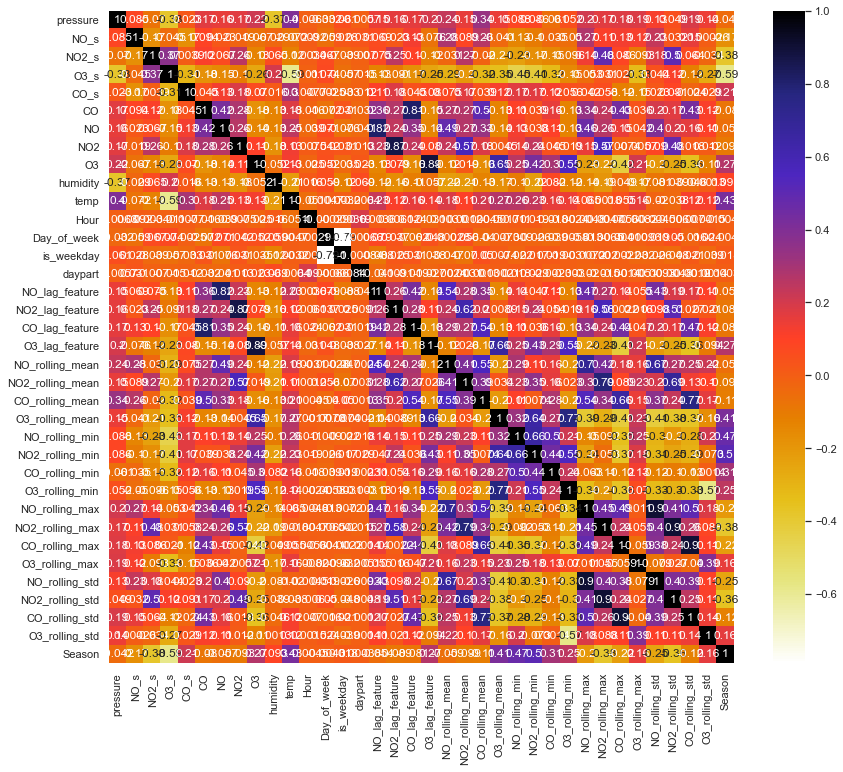

In [223]:
# Reference by Krish Naik- feature selection by correlation matrix
# Selection of feature based on Pearson's correlation analysis
# We will remove the highly correlated features (corelation among independent features)

plt.figure(figsize=(14,12))
cor = df_by_hour.drop(['spora-id', 'latitude', 'longitude', 'Day_of_month', 'Month', 'Day'], axis=1).corr()
svm =sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r) # family='Arial', fontsize=14
figure= svm.get_figure()
figure.savefig('heatmap_correlation_matrix.png')
#plt.show()

In [224]:
# let's wirte a function for selecting highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set() # set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in abosolute coeff value
                colname= corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    return col_corr

In [225]:
corr_features = correlation(df_by_hour, 0.8)
len(set(corr_features))

9

In [226]:
corr_features

{'CO_lag_feature',
 'CO_rolling_std',
 'NO2_lag_feature',
 'NO2_rolling_std',
 'NO_lag_feature',
 'NO_rolling_std',
 'O3_lag_feature',
 'Season',
 'longitude'}

#### Saving the data

In [173]:
df_by_hour.head(2)

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,2.0,60.166311,24.936104,100619.981389,0.070114,0.000004,0.059470,0.013797,0.032472,0.010423,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,2.0,60.183847,24.937203,100585.411944,0.053840,0.000004,0.059184,0.008911,0.032613,0.009536,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [227]:
df_by_hour.to_csv('C:/Users/Rabbil/Documents/BDA_thesis/Notebooks/cleaned_df_final.csv')

In [ ]:
#############################################################################################

### Machine learning data preparation 

In [143]:
#df_by_hour.drop(['Day_of_month', 'Month', 'Day'], axis=1, inplace=True)


In [151]:
# We will took the data from Feb to June as after June there was few data recorded
df_ml = df_by_hour.loc['2019-02':'2019-06']
df_ml.tail()

,spora-id,latitude,longitude,pressure,NO_s,NO2_s,O3_s,CO_s,CO,NO,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-06-30 19:00:00,3.0,60.170498,24.935496,101275.342043,0.055463,0.000351,0.001295,0.01183,0.043826,0.098696,...,0.043826,0.000215,0.100468,0.017497,0.087769,0.011811,0.031166,0.004421,0.011859,0.002628
2019-06-30 20:00:00,3.0,60.170498,24.935496,101275.342043,0.055463,0.000351,0.001295,0.01183,0.043826,0.098696,...,0.043826,0.000215,0.100468,0.017497,0.087769,0.011811,0.030516,0.004329,0.011216,0.002627
2019-06-30 21:00:00,3.0,60.170498,24.935496,101275.342043,0.055463,0.000351,0.001295,0.01183,0.043826,0.098696,...,0.043826,0.000215,0.100468,0.017497,0.087769,0.011811,0.029825,0.004231,0.010513,0.002627
2019-06-30 22:00:00,3.0,60.170498,24.935496,101275.342043,0.055463,0.000351,0.001295,0.01183,0.043826,0.098696,...,0.043826,0.000215,0.100468,0.017497,0.087769,0.011811,0.029089,0.004127,0.009737,0.002626
2019-06-30 23:00:00,3.0,60.170498,24.935496,101275.342043,0.055463,0.000351,0.001295,0.01183,0.043826,0.098696,...,0.043826,0.000215,0.100468,0.017497,0.087769,0.011811,0.028306,0.004016,0.008871,0.002625


In [152]:
df_ml.isnull().sum()

spora-id            0
latitude            0
longitude           0
pressure            0
NO_s                0
NO2_s               0
O3_s                0
CO_s                0
CO                  0
NO                  0
NO2                 0
O3                  0
humidity            0
temp                0
Hour                0
Day_of_week         0
Day_of_month        0
Month               0
Day                 0
is_weekday          0
daypart             0
NO_lag_feature      0
NO2_lag_feature     0
CO_lag_feature      0
O3_lag_feature      0
NO_rolling_mean     0
NO2_rolling_mean    0
CO_rolling_mean     0
O3_rolling_mean     0
NO_rolling_min      0
NO2_rolling_min     0
CO_rolling_min      0
O3_rolling_min      0
NO_rolling_max      0
NO2_rolling_max     0
CO_rolling_max      0
O3_rolling_max      0
NO_rolling_std      0
NO2_rolling_std     0
CO_rolling_std      0
O3_rolling_std      0
dtype: int64

In [153]:
df_ml.drop(['Day_of_month', 'Month', 'Day', 'daypart'], axis=1, inplace=True)

C:\Users\Rabbil\anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
df_ml.columns

Index(['spora-id', 'latitude', 'longitude', 'pressure', 'NO_s', 'NO2_s',
       'O3_s', 'CO_s', 'CO', 'NO', 'NO2', 'O3', 'humidity', 'temp', 'Hour',
       'Day_of_week', 'is_weekday', 'NO_lag_feature', 'NO2_lag_feature',
       'CO_lag_feature', 'O3_lag_feature', 'NO_rolling_mean',
       'NO2_rolling_mean', 'CO_rolling_mean', 'O3_rolling_mean',
       'NO_rolling_min', 'NO2_rolling_min', 'CO_rolling_min', 'O3_rolling_min',
       'NO_rolling_max', 'NO2_rolling_max', 'CO_rolling_max', 'O3_rolling_max',
       'NO_rolling_std', 'NO2_rolling_std', 'CO_rolling_std',
       'O3_rolling_std'],
      dtype='object')

In [155]:
# Spliting the data into train and test sets
train_size = int(len(df_ml)*0.8)
test_size = len(df_ml) - train_size

train, test = df_ml.iloc[0:train_size], df_ml.iloc[train_size:len(df_ml)]

print(train.shape, test.shape)

(2337, 37) (585, 37)


In [156]:
# Scaling of data
from sklearn.preprocessing import RobustScaler, MinMaxScaler
#from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# creating variables for list of columns with scaler
feature_columns = ['pressure', 'temp', 'NO_s',
       'NO2_s', 'O3_s', 'CO_s', 'CO', 'NO', 'O3', 'humidity', 'Hour',
       'Day_of_week', 'is_weekday',
       'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
       'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
       'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
       'CO_rolling_max', 'O3_rolling_max', 'O3_rolling_std']
#target_columns = ['NO2']

feature_transformer = MinMaxScaler()
NO2_transformer = MinMaxScaler()

# fit the scaler on training data
feature_transformer = feature_transformer.fit(train[feature_columns].to_numpy())
NO2_transformer = NO2_transformer.fit(train[['NO2']])

In [157]:
train.loc[:, feature_columns] = feature_transformer.transform(train[feature_columns].to_numpy())
train['NO2'] = NO2_transformer.transform(train[['NO2']])

test.loc[:, feature_columns] = feature_transformer.transform(test[feature_columns].to_numpy())
test['NO2'] = NO2_transformer.transform(test[['NO2']])

C:\Users\Rabbil\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Rabbil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Rabbil\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [158]:
# Making the time series data into sub sequences by writing a funciton
# split a multivariate sequene into samples
import numpy as np 
def create_dataset(X, y, time_steps=1): # X=features, y=labels, time_steps= history of sequence
    Xs, ys = [], [] # create two lists
    for i in range(len(X) - time_steps): #loops for the subsequent steps
        values = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs, dtype=np.float), np.array(ys, dtype=np.float)

#x = np.asarray(x).astype('float32')

In [159]:
# Specify number of time steps
TIME_STEPS = 24 # history of 24 hours to predict for the next 24 hours

# Creating actual taining and test dataset
# Reshaping to samples, time_steps and n_features
X_train, y_train = create_dataset(train, train.NO2, time_steps= TIME_STEPS)
X_test, y_test = create_dataset(test, test.NO2, time_steps= TIME_STEPS)


In [160]:
# printing number of samples, number of time_steps and number of features
print(X_train.shape, y_train.shape)

(2313, 24, 37) (2313,)


In [161]:
print(X_test.shape, y_test.shape)

(561, 24, 37) (561,)


In [162]:
# print the first sequence
#X_test[0].shape
X_test[0][0].shape, X_train[0][0].shape

((37,), (37,))

In [163]:
#train_X[:2, :].view()
#array([[4.6, 3.1, 1.5, 0.2],
#       [5.9, 3.0, 5.1, 1.8]], dtype=object)
#train_X = train_X.astype(np.float32)
#array([[4.6, 3.1, 1.5, 0.2],
#       [5.9, 3. , 5.1, 1.8]], dtype=float32)

In [164]:
#X_train[:2, :].view()

In [165]:
### CNN model
import tensorflow as tf
from tensorflow import keras

import numpy as np
from numpy import array
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [166]:
# define model
model_cnn = Sequential()
#input_shape=(n_steps, n_features)
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            4800      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                35250     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 40,101
Trainable params: 40,101
Non-trainable params: 0
_________________________________________________________________


In [167]:
cnn_history_med = model_cnn.fit(X_train, y_train, 
                        epochs = 30,
                        batch_size=32,
                        validation_split=0.3,
                        shuffle=False
                       )

Epoch 1/30
51/51 [==============================] - 1s 10ms/step - loss: 2.9078 - val_loss: 0.1002
Epoch 2/30
51/51 [==============================] - 0s 4ms/step - loss: 0.3496 - val_loss: 0.1335
Epoch 3/30
51/51 [==============================] - 0s 3ms/step - loss: 0.3336 - val_loss: 0.0345
Epoch 4/30
51/51 [==============================] - 0s 4ms/step - loss: 0.2279 - val_loss: 0.0615
Epoch 5/30
51/51 [==============================] - 0s 4ms/step - loss: 0.1970 - val_loss: 0.0653
Epoch 6/30
51/51 [==============================] - 0s 3ms/step - loss: 0.1261 - val_loss: 0.0386
Epoch 7/30
51/51 [==============================] - 0s 4ms/step - loss: 0.0880 - val_loss: 0.0270
Epoch 8/30
51/51 [==============================] - 0s 3ms/step - loss: 0.0898 - val_loss: 0.0240
Epoch 9/30
51/51 [==============================] - 0s 4ms/step - loss: 0.0908 - val_loss: 0.0356
Epoch 10/30
51/51 [==============================] - 0s 4ms/step - loss: 0.1128 - val_loss: 0.2239
Epoch 11/30
51/51 

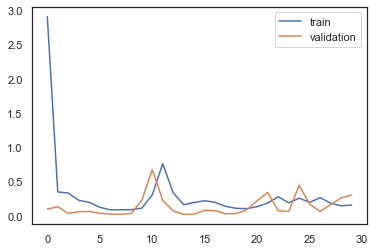

In [168]:
# Plotting
plt.plot(cnn_history_med.history['loss'], label='train')
plt.plot(cnn_history_med.history['val_loss'], label='validation')
plt.legend()
plt.savefig('CNN_NO2_1_for_further_test')

In [175]:
# making prediction
y_pred_cnn = model_cnn.predict(X_test)
import sklearn.metrics as metrics # for model evaluation 
#from sklearn.metrics import mean_absolute_percentage_error
# Model evaluation using mean square error (MSE)
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_cnn))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_cnn)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_cnn))
# Model evaluation using mean absolute percentage error (MAPE)
#print('Mean Absolute Error:' , metrics.mean_absolute_percentage_error(y_test, y_pred_cnn))

Mean Squared Error: 0.21799672918232238
Root Mean Squared Error: 0.46690119852311623
Mean Absolute Error: 0.39064483561883484


In [ ]:
# Lstm model

In [176]:
model_lstm = keras.Sequential()
model_lstm.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(units = 128, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)

# add dropout layer
model_lstm.add(keras.layers.Dropout(rate=0.2))
model_lstm.add(keras.layers.Dense(units=1))

# compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')


In [177]:
# train the model using fit method
history_LSTM_med = model_lstm.fit(
    X_train, y_train,
    epochs = 30,
    batch_size=32,
    validation_split=0.3,
    shuffle=False
)

Epoch 1/30
51/51 [==============================] - 4s 73ms/step - loss: 0.1887 - val_loss: 0.0263
Epoch 2/30
51/51 [==============================] - 2s 39ms/step - loss: 0.1424 - val_loss: 0.0171
Epoch 3/30
51/51 [==============================] - 2s 40ms/step - loss: 0.1079 - val_loss: 0.0265
Epoch 4/30
51/51 [==============================] - 2s 39ms/step - loss: 0.0842 - val_loss: 0.0130
Epoch 5/30
51/51 [==============================] - 2s 36ms/step - loss: 0.0669 - val_loss: 0.0116
Epoch 6/30
51/51 [==============================] - 2s 40ms/step - loss: 0.0568 - val_loss: 0.0100
Epoch 7/30
51/51 [==============================] - 2s 39ms/step - loss: 0.0528 - val_loss: 0.0102
Epoch 8/30
51/51 [==============================] - 2s 38ms/step - loss: 0.0441 - val_loss: 0.0154
Epoch 9/30
51/51 [==============================] - 2s 37ms/step - loss: 0.0422 - val_loss: 0.0132
Epoch 10/30
51/51 [==============================] - 2s 38ms/step - loss: 0.0401 - val_loss: 0.0140
Epoch 11/

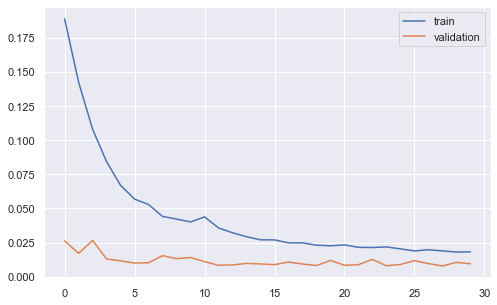

In [178]:
plt.plot(history_LSTM_med.history['loss'], label='train')
plt.plot(history_LSTM_med.history['val_loss'], label='validation')
plt.legend()
plt.savefig('LSTM_NO2')

In [179]:
# making prediction
y_pred_lstm = model_lstm.predict(X_test)
import sklearn.metrics as metrics # for model evaluation 
#from sklearn.metrics import mean_absolute_percentage_error
# Model evaluation using mean square error (MSE)
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_lstm))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_lstm)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_lstm))
# Model evaluation using mean absolute percentage error (MAPE)
#print('Mean Absolute Error:' , metrics.mean_absolute_percentage_error(y_test, y_pred_cnn))

Mean Squared Error: 0.010650818038471484
Root Mean Squared Error: 0.10320280053599071
Mean Absolute Error: 0.07671493993161219


In [183]:
model_gru = keras.Sequential()
model_gru.add(
    keras.layers.Bidirectional(
        keras.layers.GRU(units = 128, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)

# add dropout layer
model_gru.add(keras.layers.Dropout(rate=0.2))
model_gru.add(keras.layers.Dense(units=1))

# compile the model
model_gru.compile(loss='mean_squared_error', optimizer='adam')


In [184]:
# train the model using fit method
history_GRU = model_gru.fit(
    X_train, y_train,
    epochs = 30,
    batch_size=32,
    validation_split=0.3,
    shuffle=True
)

Epoch 1/30
51/51 [==============================] - 2s 46ms/step - loss: 0.3666 - val_loss: 0.0503
Epoch 2/30
51/51 [==============================] - 2s 31ms/step - loss: 0.2315 - val_loss: 0.0194
Epoch 3/30
51/51 [==============================] - 2s 32ms/step - loss: 0.1851 - val_loss: 0.0242
Epoch 4/30
51/51 [==============================] - 2s 31ms/step - loss: 0.1333 - val_loss: 0.0140
Epoch 5/30
51/51 [==============================] - 2s 31ms/step - loss: 0.1026 - val_loss: 0.0135
Epoch 6/30
51/51 [==============================] - 2s 33ms/step - loss: 0.0777 - val_loss: 0.0102
Epoch 7/30
51/51 [==============================] - 2s 33ms/step - loss: 0.0604 - val_loss: 0.0175
Epoch 8/30
51/51 [==============================] - 2s 31ms/step - loss: 0.0498 - val_loss: 0.0218
Epoch 9/30
51/51 [==============================] - 2s 32ms/step - loss: 0.0401 - val_loss: 0.0151
Epoch 10/30
51/51 [==============================] - 2s 32ms/step - loss: 0.0297 - val_loss: 0.0094
Epoch 11/

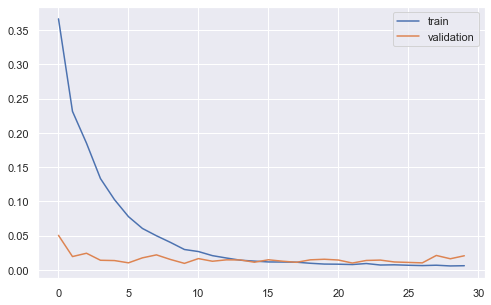

In [185]:
plt.plot(history_GRU.history['loss'], label='train')
plt.plot(history_GRU.history['val_loss'], label='validation')
plt.legend()
plt.savefig('GRU_NO2')

In [186]:
# making prediction
y_pred_gru = model_gru.predict(X_test)
import sklearn.metrics as metrics # for model evaluation 
#from sklearn.metrics import mean_absolute_percentage_error
# Model evaluation using mean square error (MSE)
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_gru))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_gru)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_gru))
# Model evaluation using mean absolute percentage error (MAPE)
#print('Mean Absolute Error:' , metrics.mean_absolute_percentage_error(y_test, y_pred_cnn))

Mean Squared Error: 0.006707316980543213
Root Mean Squared Error: 0.0818982110948903
Mean Absolute Error: 0.0648363216085905


In [187]:
# making prediction for the gru model 
y_pred_gru = model_gru.predict(X_test)


In [188]:
# use inverse the scaler for the feature variable
# invert the X_train, y_train and predicted data
y_train_inv = NO2_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = NO2_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = NO2_transformer.inverse_transform(y_pred_gru)

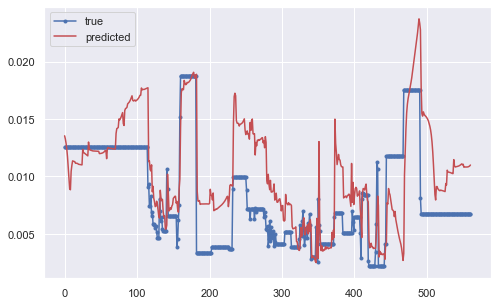

In [189]:
# plotting the predicted value
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
plt.legend()
plt.savefig('Plot_prediction_gru_NO2')

In [ ]:
# in the plot x axis is the number of timestamps that has been processed